In [615]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from more_itertools import flatten
import nltk
import wget

%matplotlib inline

## Exploratory Data Analysis of Finance & Accounting Udemy Course Titles
### *By Calvin Du*

This project aims to explore what makes an Udemy course popular by a variety of different variables. My primary focus will be to analyze how the title of a course influences it's average rating and number of subscribers. 

How I'll be doing this is through various methods of language processing and statistical procedures to judge how influential the topic is. Though there is no "Subject" column in this database, I aim to introduce one by different manipulations of the dataset. 

This analysis can help Udemy course creators to make informed decisions about their own course offerings, the titling of their courses, and can also be useful for students looking to identify the most popular and effective courses on the platform.


### **Part 1) Loading and the Cleaning the Data** 

In [616]:
df = pd.read_csv("Udemy.csv")

In [617]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13608 entries, 0 to 13607
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            13608 non-null  int64  
 1   title                         13608 non-null  object 
 2   url                           13608 non-null  object 
 3   is_paid                       13608 non-null  bool   
 4   num_subscribers               13608 non-null  int64  
 5   avg_rating                    13608 non-null  float64
 6   avg_rating_recent             13608 non-null  float64
 7   rating                        13608 non-null  float64
 8   num_reviews                   13608 non-null  int64  
 9   is_wishlisted                 13608 non-null  bool   
 10  num_published_lectures        13608 non-null  int64  
 11  num_published_practice_tests  13608 non-null  int64  
 12  created                       13608 non-null  object 
 13  p

Looking at the initial information about the dataset, I notice a few things: 
- The Price amounts are in INR currency, so I'll first switch this to CAD to be more understandable to me as well as remove the columns displaying price currency and price as a string as I now know it's in CAD. I also want to change prices that are empty (NaN) to 0

Some other adjustments I'll make is to:
- Remove the _url_, _id_  and _rating_ column as it serves no purpose in my analysis
- Change the Dtype of columns such as prices -> numeric and the dates -> datetime
- Change the names of columns like "discount_price__amount" have more intuitive names 

Another thing to note is that Udemy courses are generally always on sale, so any analysis on prices will be on the discounted prices

In [618]:
print(df["discount_price__currency"].unique().tolist())
print(df["price_detail__currency"].unique().tolist())
#This shows me that the only currencies are INR or Null therefore I can convert all the prices to CAD with one conversion 

df["discount_price__amount"] = pd.to_numeric(df["discount_price__amount"])
df["price_detail__amount"] = pd.to_numeric(df["price_detail__amount"])
df["created"] = pd.to_datetime(df["created"])
df["published_time"] = pd.to_datetime(df["published_time"])

#conversion rate from INR to CAD is 0.016 
df["discount_price__amount"] = df["discount_price__amount"]*0.016
df["price_detail__amount"] = df["price_detail__amount"]*0.016

df = df.drop(["discount_price__currency","discount_price__price_string","price_detail__currency","price_detail__price_string", "price_detail__amount", "avg_rating_recent"], axis = 1)

df["discount_price__amount"] = df["discount_price__amount"].fillna(0)

df = df.drop(["url", "id", "rating", "is_wishlisted"], axis = 1)

names = {"discount_price__amount": "price"}
df = df.rename(columns=names)
df.info()

['INR', nan]
['INR', nan]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13608 entries, 0 to 13607
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   title                         13608 non-null  object             
 1   is_paid                       13608 non-null  bool               
 2   num_subscribers               13608 non-null  int64              
 3   avg_rating                    13608 non-null  float64            
 4   num_reviews                   13608 non-null  int64              
 5   num_published_lectures        13608 non-null  int64              
 6   num_published_practice_tests  13608 non-null  int64              
 7   created                       13608 non-null  datetime64[ns, UTC]
 8   published_time                13608 non-null  datetime64[ns, UTC]
 9   price                         13608 non-null  float64            
dtypes: bool(

### **Part 2) Preliminary Analysis**

Since the data cleanup is done, I can do some initial analysis to see how various variables affect how popular/good a course is by looking at both **average rating** and **number of subscribers** as the response variables. The reason I chose these as the response variables are because
- Average rating is an indicator of how much someone likes the course 
- But generally these ratings can be influenced by many factors (such as difficulty) so I also choose to include number of subscribers to show an indication of general interest of the course 

The following plots will look at the following isolated explanatory variables using a sample of 3000 for less crowded visualizations 
- Discounted Price
- Number of lectures



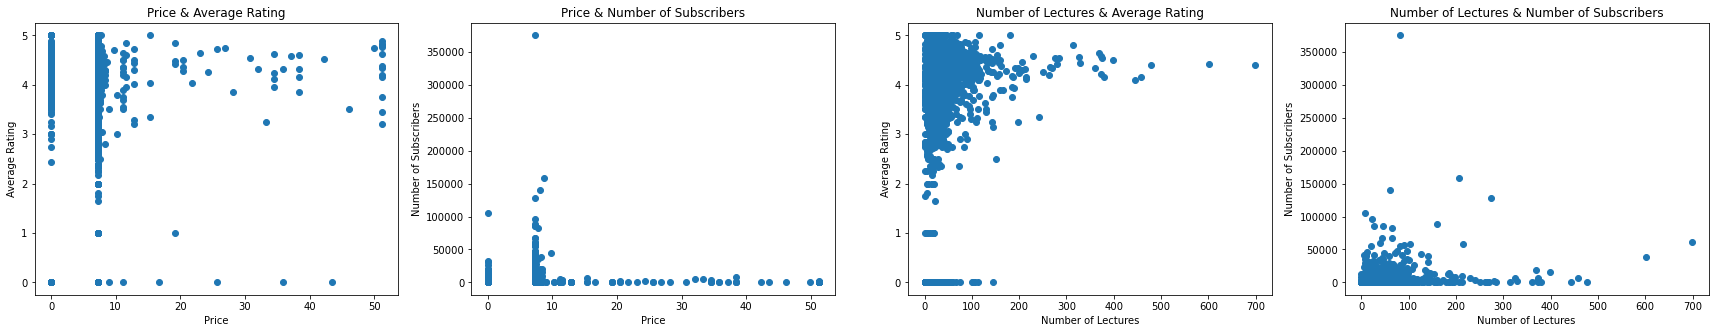

In [619]:
df_sample = df.sample(n=3000, random_state=1)
xprice = df_sample["price"]
xlecturenum = df_sample["num_published_lectures"]
yrating = df_sample["avg_rating"]
ynumsub = df_sample["num_subscribers"]


fig, ax = plt.subplots(1,4)

ax[0].scatter(xprice, yrating)
ax[1].scatter(xprice, ynumsub)
ax[2].scatter(xlecturenum, yrating)
ax[3].scatter(xlecturenum, ynumsub)   

fig.set_size_inches(30,5)

xname = ["Price", "Price", "Number of Lectures", "Number of Lectures"]
yname = ["Average Rating", "Number of Subscribers","Average Rating", "Number of Subscribers"]
for i in range(len(ax)):
    xaxis_name = xname[i]
    yaxis_name = yname[i] 
    ax[i].set_title(f"{xaxis_name} & {yaxis_name}")
    ax[i].set_xlabel(xaxis_name)
    ax[i].set_ylabel(yaxis_name)

There's no real tell-tale sign of price having a big affect on the response variables (rating/number of subscribers)

While I can make indications about the number of lectures and the rating and number of subscribers, the density can be attributed to the fact that most courses have ~100 published lectures lectures and therefore have more courses with lower subscribers

This can be seen when looking at the correlations between the variables

In [620]:
print(df.corr()[["price","num_published_lectures"]].loc[["avg_rating","num_subscribers"]])
df.corr()

                    price  num_published_lectures
avg_rating       0.036752                0.116836
num_subscribers -0.016390                0.211672


,is_paid,num_subscribers,avg_rating,num_reviews,num_published_lectures,num_published_practice_tests,price
is_paid,1.000000,-0.062120,-0.006946,-0.008134,0.070470,0.033849,0.292306
num_subscribers,-0.062120,1.000000,0.082100,0.784190,0.211672,-0.028835,-0.016390
avg_rating,-0.006946,0.082100,1.000000,0.068631,0.116836,-0.069611,0.036752
num_reviews,-0.008134,0.784190,0.068631,1.000000,0.179063,-0.005810,0.000933
num_published_lectures,0.070470,0.211672,0.116836,0.179063,1.000000,-0.068715,0.045015
num_published_practice_tests,0.033849,-0.028835,-0.069611,-0.005810,-0.068715,1.000000,0.027265
price,0.292306,-0.016390,0.036752,0.000933,0.045015,0.027265,1.000000


Looking at the correlations for my chosen variables as well as everything in general, I see there isn't too much correlation in anything. 

- In regards to the rating, this can be due to people just generally rating the courses they buy highly as seen by a bias towards the 5 star
- For the number of subscribers, as most courses are under $10, it doesn't seem to affect the ratings much and while it does to be a bit more influenced by the number of lectures, it's still a weak correlation

While variables like price and number of lectures can have some impact on a course's popularity and rating, what I believe to be the most important factor in these variables is the title of the course itself. As mentioned above, I aim to prove this through looking at the title of the lectures and using a variety of methods to showcase different ways the title influences the popularity of a course such as by guessing it's topic/subject and through the use of key words. 

### **Part 3) Analyzing the Title & Key Words** 

What I'll first be doing is looking at the words in the dataset itself. I'll be looking at the frequency a word appears in the titles of the dataset in order to get a list of these words and to know how often they appear 

In [621]:
def splitstring(x): 
    return x.split()

def lowercase(x): 
    return x.lower()

string_series = df["title"].apply(lowercase)
string_series = string_series.apply(splitstring)

string_list = pd.Series(list(flatten(string_series)))
counts = string_list.value_counts()

counts = counts.reset_index()
counts.columns = ["word","count"]
counts

,word,count
0,to,2870
1,-,2020
2,for,1858
3,a,1764
4,the,1640
...,...,...
12889,xrp:,1
12890,sixsigma,1
12891,icbb,1
12892,(va),1


Unsurprisingly, words like "to", "a" or symbols like "-" rank the highest in terms of frequency. To counter this I'll remove what is commonly referred to as *Stop Words* which are words that have no value in terms of analysis. The list of words I'll be using as my list of Stop Words is downloaded from an online source instead of the usual NLTK Stop Words List (commonly used in NLP) because it contains more words that commonly come up in course titles. In addition to this, I'll remove words like "course" and "guide" as they can be thought of as Stop Words as well

I'll also be removing words that are insigificant in frequency. I choose the arbitrary value of a frequency <= 25. 

In [622]:
wget.download("https://gist.githubusercontent.com/ZohebAbai/513218c3468130eacff6481f424e4e64/raw/b70776f341a148293ff277afa0d0302c8c38f7e2/gist_stopwords.txt")

textfile = open("gist_stopwords.txt", "r")
content = textfile.read()
stop_words = content.split(",")
textfile.close()
stop_words.extend(['-','&','1','|',':', 'guide', 'course', 'complete', 'learn', 'de','2020','start','online'])

identified_counts = counts["word"].apply(lambda x: x in stop_words)
insignificant_counts = counts["count"].apply(lambda x: x <= 25)

filtered_counts = counts[~identified_counts & ~insignificant_counts]

filtered_counts.head(15)

,word,count
7,business,1453
11,trading,961
12,management,813
18,financial,515
20,analysis,425
22,forex,413
23,sales,412
24,accounting,401
30,beginners,317
31,project,308


Already I can see some interesting information. In a dataset of ***Finance and Accounting courses***, terms like "business, "trading", and "management" are the most frequently used words. These are common fields and skills in the finance industry so it's not surprising to see them so popular. I'll make a visualization to showcase the disparity of frequency of the commonly used words, outlining what the top 7 are. 

/var/folders/v_/t5rsdmlx7211p45vtv__vm0m0000gn/T/ipykernel_976/2762143916.py:9: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


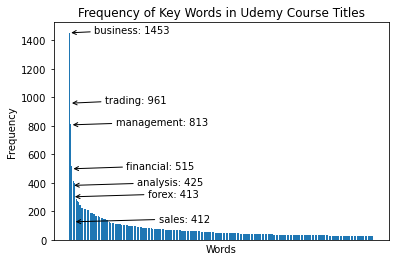

In [623]:
xaxis = filtered_counts['word']
yaxis = filtered_counts['count']

fig, ax = plt.subplots()

ax.bar(xaxis, yaxis)
ax.set_xlabel("Words")
ax.set_ylabel("Frequency")
ax.set_xticks([])
ax.set_title("Frequency of Key Words in Udemy Course Titles")

for i in range(7):
    ax.annotate(
        f"{xaxis.iloc[i]}: {yaxis.iloc[i]}", xy=(i,(yaxis.iloc[i]-(2.01**(1.35*i)))), xycoords="data",
        xytext=(25+i*10, 0), textcoords="offset points",
        arrowprops=dict(arrowstyle="->"))

Obviously something like "business" is at the top by a large margin as many course authors will want to emphasize the course's application in the business industry. Many large fields follow soon after like "trading" indicating many courses based on this subject. 

A way I aim to analyze the affect of having these key words in the course title is to use this data to find out if having these words in a title correlates to more subscribers or a higher rating. 

For example, I can do some **feature engineering** to create a new column that indiciates if a title has a top 10 key word 

In [624]:
#This code makes new series that indicates if a course has a top 10 key word in it's title
has_top_10_key_word = string_series.apply(lambda y: any(word in filtered_counts.head(10)["word"].tolist() for word in y))

In [625]:
has_top_10_key_word = has_top_10_key_word.rename("has_top_10_key_word")
has_top_10_key_word.reset_index().groupby("has_top_10_key_word").count()

,index
has_top_10_key_word,
False,8912
True,4696


This table showcases a count of how many courses have the top 10 key words in it's title, to reiterate these words are:

In [626]:
words10 = filtered_counts.head(10)["word"].tolist()
print(words10)


['business', 'trading', 'management', 'financial', 'analysis', 'forex', 'sales', 'accounting', 'beginners', 'project']


By adding the column of "has_top_10_key_word" to the original dataset, I can create visualizations to understand how influential having these key words are on an average rating and number of subscribers

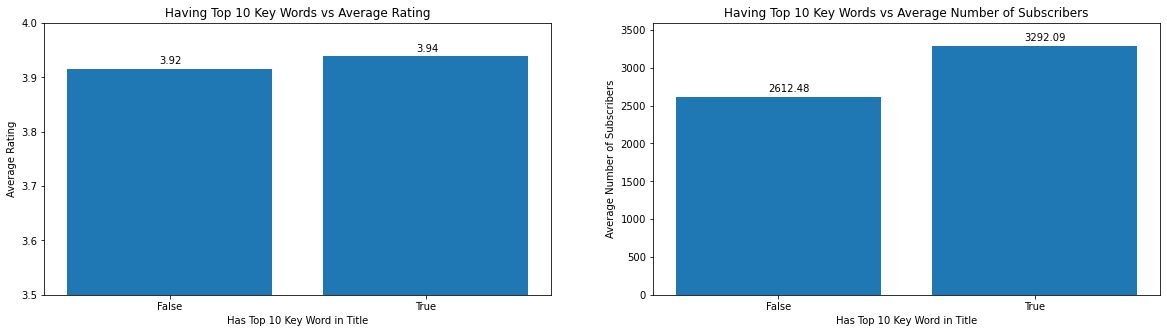

In [627]:
has_top_10_df = pd.concat([df,has_top_10_key_word], axis = 1)
results_table = has_top_10_df.groupby("has_top_10_key_word").mean()[["avg_rating","num_subscribers"]]

xaxis = ["False", "True"]
yaxis_rating = results_table["avg_rating"]
yaxis_num_subscribers = results_table["num_subscribers"]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,5)
for i in range(2):
    ax[i].set_xlabel("Has Top 10 Key Word in Title")

ax[0].bar(xaxis, yaxis_rating)
ax[0].set_title("Having Top 10 Key Words vs Average Rating")
ax[0].set_ylim([3.5,4])
ax[0].set_ylabel("Average Rating")
for i in range(2):
    ax[0].annotate(
        f"{yaxis_rating[i].round(2)}", xy=(xaxis[i],yaxis_rating[i]), xycoords="data",
        xytext=(-10, 5), textcoords="offset points")

ax[1].bar(xaxis, yaxis_num_subscribers)
ax[1].set_title("Having Top 10 Key Words vs Average Number of Subscribers")
ax[1].set_ylabel("Average Number of Subscribers")
ax[1].set_ylim([0,yaxis_num_subscribers.max()+300])
for i in range(2):
    ax[1].annotate(
        f"{yaxis_num_subscribers[i].round(2)}", xy=(xaxis[i],yaxis_num_subscribers[i]), xycoords="data",
        xytext=(-10, 5), textcoords="offset points")

While the rating is essentially the same, there is a clear difference in average number of subscribers while having these key words. In this view, this indicates that by having these popular words, the amount of subscribers goes up for a course. 

Another analysis to into more depth with these key words is if the amount of key words in the title affects the response variables. Using the same top 10 key words, I can make another column with the count of key words and do a similar analysis as above.

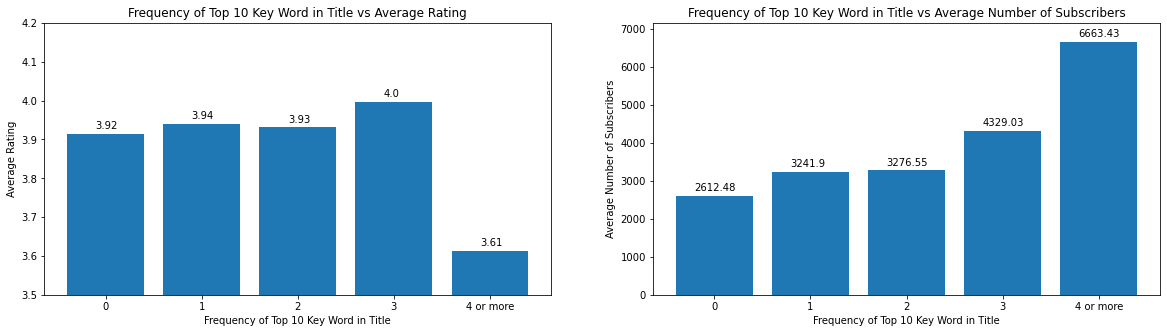

In [628]:
def count_words(words, list_of_words = filtered_counts.head(10)["word"].tolist()):
    count = 0
    for word in words:
        if word in list_of_words:
            count += 1
    if count < 4:
        return f"{count}"
    else: 
        return "4 or more"

count_top_10_key_word = string_series.apply(count_words)
count_top_10_key_word = count_top_10_key_word.rename("count_top_10_key_word")
count_top_10_df = pd.concat([has_top_10_df,count_top_10_key_word], axis=1)

results_table = count_top_10_df.groupby("count_top_10_key_word").mean()[["avg_rating","num_subscribers"]]

xaxis = list(results_table.index)
yaxis_rating = results_table["avg_rating"]
yaxis_numsubscribers = results_table["num_subscribers"]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,5)
for i in range(2):
    ax[i].set_xlabel("Frequency of Top 10 Key Word in Title")

ax[0].bar(xaxis, yaxis_rating)
ax[0].set_title("Frequency of Top 10 Key Word in Title vs Average Rating")
ax[0].set_ylabel("Average Rating")
ax[0].set_ylim([3.5,4.2])
for i in range(5):
    ax[0].annotate(
        f"{yaxis_rating[i].round(2)}", xy=(xaxis[i],yaxis_rating[i]), xycoords="data",
        xytext=(-10, 5), textcoords="offset points")

ax[1].bar(xaxis, yaxis_numsubscribers)
ax[1].set_title("Frequency of Top 10 Key Word in Title vs Average Number of Subscribers")
ax[1].set_ylabel("Average Number of Subscribers")
ax[1].set_ylim([0,yaxis_numsubscribers.max()+500])
freq_avg = np.zeros(5) # to be used later
for i in range(5):
    ax[1].annotate(
        f"{yaxis_numsubscribers[i].round(2)}", xy=(xaxis[i],yaxis_numsubscribers[i]), xycoords="data",
        xytext=(-20, 5), textcoords="offset points")

    freq_avg[i] = (yaxis_numsubscribers[i]) #to be used later 

This shows some interesting results
- For the **Average Rating**, there's little relationship either than seeing that courses with titles that have 4 or more key words have a significant lower average rating than the rest. It's difficult to say why this is, as rating is often an indicator of difficulty, the instructor's ability or the content itself, so the key words in the title have little impact on how the customers view the course itself and no definite conclusions can be made


- For **Number of Subscribers** on the other hand, people will only subscribe to courses they view as appealing before they actually experience the course. Of course there are outside factors such as the course's reputation or the descriptions that come with the course but there is clear correlation with having more key words leading to a higher number of subscribers

**To go even further**, I can do the same analysis as the two above but instead use the specific words in the top 10 individually. 

As mentioned in the previous analysis, since the number of subscribers is what is generally affected rather than rating, the following analysis will only be looking at the response of **number of subscribers** for each word

For the sake of fitting all the data on the visualizaition neatly, I'll only be using the top 5 key words. As above these are:
- business
- trading
- management
- financial
- analysis

/var/folders/v_/t5rsdmlx7211p45vtv__vm0m0000gn/T/ipykernel_976/1942129285.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([" "] + list_of_words)


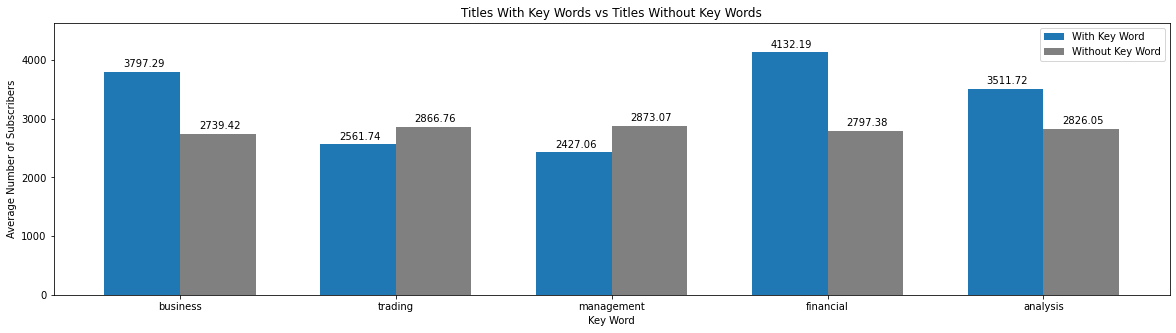

In [629]:
list_of_words = filtered_counts.head(5)["word"].tolist()

ywith_word = []
ywithout_word = []

for i in range(len(list_of_words)):
    given_word = list_of_words[i]
    def has_word(x): 
        return any(word == given_word for word in x)
    
    series = string_series.apply(has_word)
    ywith_word.append(df[series]["num_subscribers"].mean())
    ywithout_word.append(df[~series]["num_subscribers"].mean())

fig, ax = plt.subplots()
fig.set_size_inches(20,5)
bin_index = np.arange(len(list_of_words))
width = 0.35
ax.set_xlabel("Key Word")
ax.set_ylabel("Average Number of Subscribers")
ax.set_ylim(0,max(ywith_word)+500)
ax.set_title("Titles With Key Words vs Titles Without Key Words")
ax.bar(bin_index-width/2, ywith_word, width, label = "With Key Word")
ax.bar(bin_index+width/2, ywithout_word, width, color='grey', label = "Without Key Word")
ax.set_xticklabels([" "] + list_of_words)
ax.legend()
for i in range(len(list_of_words)):
    ax.annotate(
        f"{round(ywith_word[i],2)}", xy=(bin_index[i]-width*0.75,ywith_word[i]), xycoords="data",
        xytext=(0, 5), textcoords="offset points")
    ax.annotate(
        f"{round(ywithout_word[i],2)}", xy=(bin_index[i]+width*0.25,ywithout_word[i]), xycoords="data",
        xytext=(0, 5), textcoords="offset points")
    

Some insights that can be made from this visualization:
- I can see that courses outlining business tend to do better than those that don't 
- By looking at trading & management,I see that the average number of subscribers for courses without these key words is higher than with. This can be explained by only a few courses with these key words having many subscriberes while there are many courses that have these words in the title but have very few subscribers. 
    - I see that words like "business" and "management" which are more specific than large fields like "business", "financial" and "analysis" have this trend
    - Therefore I can draw a conclusion that titles with words with broader fields will on average, do better than courses with titles that don't 

### **Part 4) Google Trends & Key Words**

By going into https://trends.google.com/trends/?geo=CA, I can gather information about how interesting a topic is through it's interest on google. How google does this is through a **relative interest value** for a comparison of 5 words. Unfortunately since this is maxed out at 5 words, the following analysis will be focused on the top 5 key words as shown above which are: "business", "trading", "management", "financial", "analysis". 

I'll download the dataset from this link, and clean it up to be used for an analysis involving these interest values. The table will be the 5 key words along with it's relative interest value to the other key words. The following plot is a representation of how this interest changes over time (exactly the same as shown on google trends)

            business  trading  management  financial  analysis
Week                                                          
2017-12-17      0.63     0.21        0.39       0.23      0.15
2017-12-24      0.51     0.19        0.32       0.17      0.10
2017-12-31      0.63     0.18        0.41       0.23      0.12
2018-01-07      0.73     0.18        0.48       0.27      0.16
2018-01-14      0.73     0.17        0.50       0.25      0.17


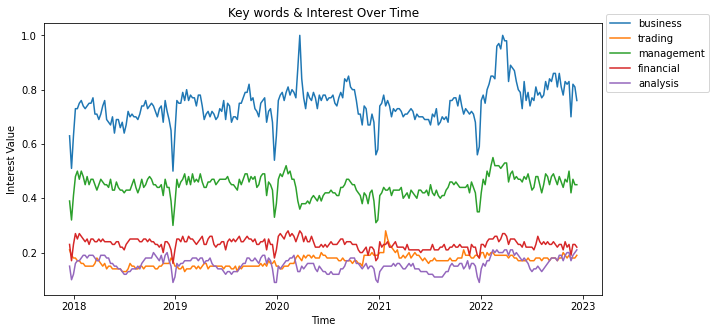

In [630]:
trends_df = pd.read_csv("googletrends.csv")
trends_df = trends_df.reset_index()
trends_df.head()
trends_df.columns = trends_df.iloc[0]
trends_df = trends_df.drop(axis=1,index=0)
trends_df.columns = ["Week", "business", "trading", "management", "financial", "analysis"]
trends_df[["business","trading","management","financial","analysis"]] = trends_df[["business","trading","management","financial","analysis"]].astype(float)
trends_df["Week"] = pd.to_datetime(trends_df["Week"])
trends_df[["business","trading","management","financial","analysis"]] = trends_df[["business","trading","management","financial","analysis"]]/100
trends_df = trends_df.set_index("Week")
trends_df.head(5)

fig, ax = plt.subplots()
fig.set_size_inches(10,5)
lines = list(trends_df.columns)
plot_trends_df = trends_df.reset_index()
xaxis = plot_trends_df["Week"]
for line in lines: 
    string_line = f"{line}"
    ax.plot(xaxis, plot_trends_df[string_line], label = string_line)
ax.legend(bbox_to_anchor=(1.2, 1.05))
ax.set_title("Key words & Interest Over Time")
ax.set_ylabel("Interest Value")
ax.set_xlabel("Time")
print(trends_df.head())


First I'll add a new column called "identified_words" to my dataset. This column will act as a way to indicate which of the top 5 words are present in each title

In [631]:
def identify_word(x, list_of_words = filtered_counts.head(5)["word"].tolist()):
    set1 = set(x)
    set2 = set(list_of_words)

    words = set1.intersection(set2)
    return words

string_series.apply(identify_word)

identified_words = string_series.apply(identify_word).rename("identified_words")
identified_df = pd.concat([count_top_10_df,identified_words], axis = 1)
identified_df[["title", "identified_words"]].head(5)

,title,identified_words
0,The Complete SQL Bootcamp 2020: Go from Zero t...,{}
1,Tableau 2020 A-Z: Hands-On Tableau Training fo...,{}
2,PMP Exam Prep Seminar - PMBOK Guide 6,{}
3,The Complete Financial Analyst Course 2020,{financial}
4,An Entire MBA in 1 Course:Award Winning Busine...,{business}


Then I'll add a column that expresses a value of interest for each course. 

These are the steps I take to implement this column:
1. Since I know these words are the top 5 most frequently used, I assume that they generate more interest than all other words, therefore these words will be standarized to be in the range [0.7,1] where all other words will be 0.5
2. I previously saw that having more than 1 of these key words generates more interest through the previous visualization showcasing how frequency of key words in title affected number of subscribers. Because of this, for every additional key word a title has, the interest value will increase
    - The amount it increases will be calculated as followed:
        1. First the title will have it's **interest value** set to the interest value of the most interesting key word (by value)
        2. Then for every additional key word, the interest will increase by 0.1

In [632]:
# Standardizes trend to [0.7,1]
def standardize_to_range(value):
  old_min = 0
  old_max = 1
  new_min = 0.7
  new_max = 1
  standardized_value = (value - old_min) * (new_max - new_min) / (old_max - old_min) + new_min
  return standardized_value

standardized_trends_df = trends_df.apply(standardize_to_range)
standardized_trends_df

# function to get interest value 
def get_interest_value(word):
  default_interest_value = 0.5
  if word in specific_interest_value:
    return specific_interest_value[word]
  else:
    return default_interest_value

specific_interest_value = {
  'business': standardized_trends_df['business'].mean(),
  'trading': standardized_trends_df['trading'].mean(),
  'management': standardized_trends_df['management'].mean(),
  'financial': standardized_trends_df['financial'].mean(),
  'analytics': standardized_trends_df['analysis'].mean()
}

def interest_value(strings):
  strings = list(strings)

  if(strings == []):
    return 0.5
  values = np.zeros(len(strings))

  for i in range(len(strings)):  
    values[i] = get_interest_value(strings[i])
  interest_value = values.max()+(values.size-1)*0.1 
  return interest_value

identified_df["interest"] = identified_df["identified_words"].apply(interest_value)
pd.concat([identified_df.head(5), identified_df.iloc[11:12]], axis = 0)

,title,is_paid,num_subscribers,avg_rating,num_reviews,num_published_lectures,num_published_practice_tests,created,published_time,price,has_top_10_key_word,count_top_10_key_word,identified_words,interest
0,The Complete SQL Bootcamp 2020: Go from Zero t...,True,295509,4.66019,78006,84,0,2016-02-14 22:57:48+00:00,2016-04-06 05:16:11+00:00,7.28,False,0,{},0.500000
1,Tableau 2020 A-Z: Hands-On Tableau Training fo...,True,209070,4.58956,54581,78,0,2016-08-22 12:10:18+00:00,2016-08-23 16:59:49+00:00,7.28,False,0,{},0.500000
2,PMP Exam Prep Seminar - PMBOK Guide 6,True,155282,4.59491,52653,292,2,2017-09-26 16:32:48+00:00,2017-11-14 23:58:14+00:00,7.28,False,0,{},0.500000
3,The Complete Financial Analyst Course 2020,True,245860,4.54407,46447,338,0,2015-10-23 13:34:35+00:00,2016-01-21 01:38:48+00:00,7.28,True,1,{financial},0.769874
4,An Entire MBA in 1 Course:Award Winning Busine...,True,374836,4.47080,41630,83,0,2015-10-12 06:39:46+00:00,2016-01-11 21:39:33+00:00,7.28,True,1,{business},0.924080
11,Business Analysis Fundamentals,True,82015,4.49968,23326,67,0,2016-02-03 23:00:19+00:00,2016-02-21 21:40:32+00:00,7.28,True,2,"{business, analysis}",1.024080


### ^^^ This is how the final dataset looks! ^^^

Some insights can be made about how this interest value affects number of subscribers in the following plots:

Text(0.5, 0, 'Interest')

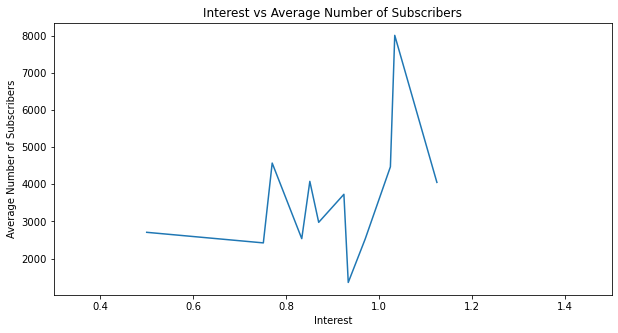

In [633]:
results = (identified_df.groupby("interest").mean()["num_subscribers"])
results = results.reset_index()

x = results["interest"]
y = results["num_subscribers"]

fig, ax = plt.subplots()
ax.plot(x,y)
fig.set_size_inches(10,5)
ax.set_xlim(0.3,1.5)
ax.set_title("Interest vs Average Number of Subscribers")
ax.set_ylabel("Average Number of Subscribers")
ax.set_xlabel("Interest")

This visualization shows an almost completely random relationship between interest on google vs number of subscribers 
- This may be because an interest with a google search does not correlate with Udemy subscriptions 
- The way I conducted in determining interest could be affecting the results as well

### **Part 5) Linear Regression and Why It Doesn't Work With My Model**

In [634]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

def change_value(string):
    if (string == "4 or more"):
        return 4
    else: 
        return string

ml_df = identified_df
ml_df["count_top_10_key_word"] = identified_df["count_top_10_key_word"].apply(change_value)

lr_model = linear_model.LinearRegression()

X = ml_df[["has_top_10_key_word","count_top_10_key_word"]]
y = ml_df["num_subscribers"]

X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.25)
lr_model.fit(X_train, y_train)

print(f"Train Score: {lr_model.score(X_train, y_train)}")
print(f"Test Score: {lr_model.score(X_test, y_test)}")


Train Score: 0.002110197361295141
Test Score: -0.0005870221107295848


Using some of my new features, I can attempt to create a linear model to predict the number of subscribers. Unfortunately, the accuracy by doing this is very low. 

The reason I assume this happens is because 
1. Like in some previous visualizations, the difference in averages of number of subscribers is mainly produced by a few very popular courses and therefore it's hard to judge because of the sheer amount of low number of subscriber courses there are
2. The variables being a boolean and very small count does not lead to fruitful prediction as there isn't much wiggle room to work with